In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import math
from functools import cmp_to_key
from multiprocessing import Process, Manager, Pool, Queue, cpu_count
import time
from tqdm import tqdm

In [2]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return np.all(center_pixel_value >= first_subimage) and \
                   np.all(center_pixel_value >= third_subimage) and \
                   np.all(center_pixel_value >= second_subimage[0, :]) and \
                   np.all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return np.all(center_pixel_value <= first_subimage) and \
                   np.all(center_pixel_value <= third_subimage) and \
                   np.all(center_pixel_value <= second_subimage[0, :]) and \
                   np.all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

In [3]:
def computeGradientAtCenterPixel(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

In [4]:
def computeHessianAtCenterPixel(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

In [5]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape
    
    scale = scale_factor * keypoint.size / np.float32(2 ** (octave_index + 1))
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = np.zeros(num_bins)
    smooth_histogram = np.zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / np.float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / np.float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                    gradient_orientation = np.rad2deg(np.arctan2(dy, dx))
                    weight = np.exp(weight_factor * (i ** 2 + j ** 2))
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = np.where(np.logical_and(smooth_histogram > np.roll(smooth_histogram, 1), smooth_histogram > np.roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < 1e-7:
                orientation = 0
            new_keypoint = cv2.KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [6]:
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = np.stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * np.dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = np.trace(xy_hessian)
        xy_hessian_det = np.linalg.det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            keypoint = cv2.KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / np.float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

In [7]:
def ComputeKeypoint_process(gaussian_images, octave_index, dog_images, threshold, contrast_threshold, image_border_width, image_index):
    keypoints = []
    first_image = dog_images[image_index]
    second_image = dog_images[image_index + 1]
    third_image = dog_images[image_index + 2]
    for i in range(image_border_width, first_image.shape[0] - image_border_width):
        for j in range(image_border_width, first_image.shape[1] - image_border_width):
            if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, 3, dog_images, 1.6, contrast_threshold, image_border_width)
                if localization_result is not None:
                    keypoint, localized_image_index = localization_result
                    keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[localized_image_index])
                    for keypoint_with_orientation in keypoints_with_orientations:
                        keypoints.append([keypoint_with_orientation.octave, keypoint_with_orientation.pt, keypoint_with_orientation.response, keypoint_with_orientation.size, keypoint_with_orientation.angle])
    return keypoints

In [8]:
def ComputeKeypoint(gaussian_images, octave_index, dog_images, threshold, contrast_threshold):
    image_border_width = 5
    keypoints = []
    manager = Manager()
    q = manager.Queue()
    process = []
    for i in range(len(dog_images) - 2):
        p = Process(target=lambda q, arg1: q.put(ComputeKeypoint_process(*arg1)), args=(q, (gaussian_images, octave_index, dog_images, threshold, contrast_threshold, image_border_width, i)))
        process.append(p)
        process[i].start()
    for i in range(len(process)):
        process[i].join()
    while not q.empty():
        tmp = q.get()
        if len(tmp) != 0: 
            for keypoint in tmp:
                keypoints.append(keypoint)
    return keypoints

In [9]:
def compareKeypoints(keypoint1, keypoint2):
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

In [10]:
def removeDuplicateKeypoints(keypoints):
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

In [11]:
def convertKeypointsToInputImageSize(keypoints):
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * np.array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

In [12]:
def unpackOctave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / np.float32(1 << octave) if octave >= 0 else np.float32(1 << -octave)
    return octave, layer, scale

In [13]:
def generateDescriptors(keypoints, gaussian_images, num, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    descriptors = []
    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = np.round(scale * np.array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = np.cos(np.deg2rad(angle))
        sin_angle = np.sin(np.deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = np.zeros((window_width + 2, window_width + 2, num_bins))

        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(np.round(hist_width * np.sqrt(2) * (window_width + 1) * 0.5))
        half_width = int(min(half_width, np.sqrt(num_rows ** 2 + num_cols ** 2)))
        
        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(np.round(point[1] + row))
                    window_col = int(np.round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                        gradient_orientation = np.rad2deg(np.arctan2(dy, dx)) % 360
                        weight = np.exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)
                

        for i in range(len(row_bin_list)):
            row_bin = row_bin_list[i] 
            col_bin = col_bin_list[i] 
            magnitude = magnitude_list[i] 
            orientation_bin = orientation_bin_list[i]
            row_bin_floor, col_bin_floor, orientation_bin_floor = np.floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()
        threshold = np.linalg.norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(np.linalg.norm(descriptor_vector), 1e-7)
        descriptor_vector = np.round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    
    return (num, np.array(descriptors, dtype='float32'))
#     return_dict[num] = descriptors

In [14]:
def ComputeKeypointsandDescriptors(img):
    # get based image with pre-smooth
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('float32') 
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR) # lowe recommend to double image to store info
    sigma = 1.6 #recommend
    assumed_blur = 0.5 #paper assumed
    sigma_diff = np.sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01)) # assumed blur * 2 because double the image size
    based_img = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff) # modify image to blur with sigma 1.6
    
    s = 3 # customized
    num_octaves = int(np.round(np.log(min(based_img.shape)) / np.log(2) - 1)) # opencv default????????
    
    # compute gaussian blur image for each octave
    num_images_per_octave = s + 3
    k = 2 ** (1. / s)    
 
    gaussian_kernels = np.zeros(num_images_per_octave)
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    image = img.copy()
    gaussian_images = []
    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    gaussian_images = np.array(gaussian_images)
    
    
    # compute dog image
    dog_images = []
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(cv2.subtract(second_image, first_image))
        dog_images.append(dog_images_in_octave)
    dog_images = np.array(dog_images)
    # compute keypoint
    contrast_threshold = 0.04
    threshold = np.floor(0.5 * contrast_threshold / s * 255)

    manager = Manager()
    q = manager.Queue()
    process = []
    for octave_index in range(len(dog_images)):
        p = Process(target=lambda q, arg1: q.put(ComputeKeypoint(*arg1)), args=(q, (gaussian_images[octave_index], octave_index, dog_images[octave_index], threshold, contrast_threshold)))
        process.append(p)
        process[octave_index].start()
    for i in range(len(process)):
        process[i].join()
    
    keypoints = []
    while not q.empty():
        for keypoint in q.get():
            tmp = cv2.KeyPoint()
            tmp.octave = keypoint[0]
            tmp.pt = keypoint[1]
            tmp.response = keypoint[2]
            tmp.size = keypoint[3]
            tmp.angle = keypoint[4]
            keypoints.append(tmp)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)

    manager = Manager()
    q = manager.Queue()
    process = []
    keypoints_number = len(keypoints)
    count = min(keypoints_number, cpu_count())
    per_process = int(keypoints_number / count)
    for i in range(count):
        down = per_process * i
        up = per_process * (i+1)
        if up > keypoints_number or i == count - 1:
            up = keypoints_number
        p = Process(target=lambda q, arg1: q.put(generateDescriptors(*arg1)), args=(q ,(keypoints[down:up], gaussian_images, i)))
        process.append(p)
        process[i].start()
    for i in range(len(process)):
        process[i].join()
    
    descriptors_no_order = []
    descriptors = []
    while not q.empty():
        descriptors_no_order.append(q.get())
    descriptors_order = sorted(descriptors_no_order, key=lambda x: x[0])
    for descriptor in descriptors_order:
        descriptors.append(descriptor[1])
    descriptors = np.concatenate(descriptors, axis=0)
    return keypoints, descriptors

In [29]:
array_of_img = []
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)

def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
    return output_img, output_img.shape[1], output_img.shape[0], H_translation
   
def cylindricalWarp(img, K):
    h_,w_ = img.shape[:2]
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3)
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T 
    B = B[:,:-1] / B[:,[-1]]
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    return cv2.remap(img, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_REPLICATE)
    
def trim(frame):
    
    if not np.sum(frame[0]):
        return trim(frame[1:])
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

def SIFT(inputname):
    read_directory(inputname)
    h, w = array_of_img[0].shape[:2]
    K = np.array([[800,0,w/2],[0,800,h/2],[0,0,1]])
    for i in range(len(array_of_img)):
        array_of_img[i] = trim(cylindricalWarp(array_of_img[i], K))

    keypoints = []
    descriptors = []
    sift = cv2.SIFT_create()
    
    for i in range(len(array_of_img)):
#         tmp_keypoint, tmp_descriptor = sift.detectAndCompute(array_of_img[i], None)
        tmp_keypoint, tmp_descriptor = ComputeKeypointsandDescriptors(array_of_img[i])
        keypoints.append(tmp_keypoint)
        descriptors.append(tmp_descriptor)
    homography= []
    for i in range(len(keypoints)-1):
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
        matches = bf.match(descriptors[i], descriptors[i+1])
        matches = sorted(matches, key=lambda x:x.distance)

        src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in matches]).reshape(-1,1,2)
        M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)        
        homography.append(M)

    all_var_width = []
    all_var_height = []
    for i in range(len(homography)):
        top = np.array([[array_of_img[i].shape[1], 0], [0, 0]], dtype=np.float)
        new_top = cv2.perspectiveTransform(top[None, :, :], homography[i])
        var_width = new_top[0][0][0] - new_top[0][1][0]
        all_var_width.append(var_width)
        translation_dist = [var_width, 0]
        W_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        top = np.array([[0, array_of_img[i].shape[0]], [0, 0]], dtype=np.float)
        new_top = cv2.perspectiveTransform(top[None, :, :], homography[i])
        var_height = new_top[0][0][1] - new_top[0][1][1]
        all_var_height.append(var_height)
        translation_dist = [0, var_height]
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        for j in range(i+1, len(homography)):
            homography[j] = W_translation.dot(homography[j])
            homography[j] = H_translation.dot(homography[j])
            
    for i in range(1, len(array_of_img)):
        original_width = array_of_img[0].shape[1]
        original_height = array_of_img[0].shape[0]
        tmp, width_of_tmp, height_of_tmp, translation = warpImages(array_of_img[0], array_of_img[i], homography[i-1])
        array_of_img[0] = trim(tmp)
        var = original_width +  all_var_width[i-1] - width_of_tmp
        translation_dist = [-var, 0]
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        var = original_height + all_var_height[i-1] - height_of_tmp
        translation_dist = [0, -var]
        W_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        for j in range(i, len(homography)):
            homography[j] = H_translation.dot(homography[j])
            homography[j] = W_translation.dot(homography[j])
            homography[j] = translation.dot(homography[j])
    imageoutput = array_of_img[0]
    array_of_img.clear()
    return imageoutput

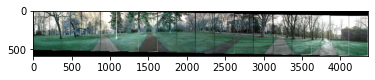

In [30]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname):
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()